In [1]:
import argparse
import os
import pathlib
import shutil

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import skimage
import tifffile
import torch
import tqdm
from PIL import Image
from rich.pretty import pprint
from stardist.models import StarDist2D
from ultrack import to_tracks_layer, track, tracks_to_zarr
from ultrack.config import MainConfig
from ultrack.imgproc import normalize
from ultrack.utils import estimate_parameters_from_labels, labels_to_contours

# check if in a jupyter notebook

try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(f"Running in notebook: {in_notebook}")

os.environ["OMP_NUM_THREADS"] = "8"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# check gpu
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if not gpu_devices:
    print("No GPU found")
else:
    print("GPU found")


# tensorflow clear gpu memory
def clear_gpu_memory():
    from numba import cuda

    cuda.select_device(0)
    cuda.close()


clear_gpu_memory()

2025-01-15 09:45:28.836078: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-15 09:45:28.836104: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-15 09:45:28.836109: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 09:45:28.840308: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running in notebook: True
GPU found


2025-01-15 09:45:31.699846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-15 09:45:31.727268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-15 09:45:31.730261: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
if not in_notebook:
    print("Running as script")
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir_main",
        type=str,
        help="Path to the input directory containing the tiff images",
    )
    parser.add_argument(
        "--input_dir_terminal",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    parser.add_argument(
        "--n_trials",
        type=int,
        default=100,
        help="Number of trials to run for the tracking algorithm",
    )

    args = parser.parse_args()
    input_dir_main = pathlib.Path(args.input_dir_main).resolve(strict=True)
    input_dir_terminal = pathlib.Path(args.input_dir_terminal).resolve(strict=True)
    n_trials = args.n_trials
else:
    print("Running in a notebook")
    input_dir_main = pathlib.Path(
        "../../2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_6hr_4ch_MaxIP_C-03_F0001"
    ).resolve(strict=True)
    input_dir_terminal = pathlib.Path(
        f"../../2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_{str(input_dir_main).split('MaxIP_')[1]}"
    ).resolve(strict=True)
    n_trials = 50

temporary_output_dir = pathlib.Path("../tmp_output").resolve()
figures_output_dir = pathlib.Path("../figures").resolve()
results_output_dir = pathlib.Path("../results").resolve()
temporary_output_dir.mkdir(exist_ok=True)
figures_output_dir.mkdir(exist_ok=True)
results_output_dir.mkdir(exist_ok=True)

Running in a notebook


In [3]:
file_extensions = {".tif", ".tiff"}
# get all the tiff files
tiff_files = list(input_dir_main.glob("*"))
tiff_files = [f for f in tiff_files if f.suffix in file_extensions]
tiff_files = sorted(tiff_files)

tiff_files_terminal = list(input_dir_terminal.glob("*"))
tiff_files_terminal = [f for f in tiff_files_terminal if f.suffix in file_extensions]
tiff_files_terminal = sorted(tiff_files_terminal)

tiff_files = tiff_files + tiff_files_terminal
tiff_files = [f for f in tiff_files if "C01" in f.name]

print(f"Found {len(tiff_files)} tiff files in the input directory")

Found 14 tiff files in the input directory


In [4]:
model = StarDist2D.from_pretrained("2D_versatile_fluo")

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2025-01-15 09:45:31.966065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-15 09:45:31.967212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-15 09:45:31.968273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
image_dims = tifffile.imread(tiff_files[0]).shape
timelapse_raw = np.zeros(
    (len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16
)
timelapse_raw_visualize = np.zeros(
    (len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16
)
stardist_labels = np.zeros(
    (len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16
)

In [6]:
# loop over all the images
max_number_of_objects = 0
print(f"Segmenting {len(tiff_files)} images")
for image_index, image_file_path in tqdm.tqdm(enumerate(tiff_files)):
    image = tifffile.imread(image_file_path)
    timelapse_raw_visualize[image_index, :, :] = image
    image = normalize(image, gamma=1.0)
    timelapse_raw[image_index, :, :] = image

    segmented_image, _ = model.predict_instances(image)
    stardist_labels[image_index, :, :] = segmented_image
    if len(np.unique(segmented_image)) > max_number_of_objects:
        max_number_of_objects = len(np.unique(segmented_image))
# concat all the images into one array
print(stardist_labels.shape)
# get the number of unqiue labels in the labels
print(f"Found {max_number_of_objects} unique labels in the stardist labels")

Segmenting 14 images


0it [00:00, ?it/s]2025-01-15 09:45:32.799634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
14it [00:06,  2.09it/s]

(14, 1900, 1900)
Found 218 unique labels in the stardist labels


In [7]:
detections = np.zeros((len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16)
edges = np.zeros((len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16)
for frame_index, frame in enumerate(stardist_labels):
    detections[frame_index, :, :], edges[frame_index, :, :] = labels_to_contours(frame)
print(detections.shape, edges.shape)
tifffile.imwrite(f"{temporary_output_dir}/stardist_labels.tif", stardist_labels)
tifffile.imwrite(f"{temporary_output_dir}/timelapse_raw.tif", timelapse_raw)
tifffile.imwrite(f"{temporary_output_dir}/detections.tif", detections)
tifffile.imwrite(f"{temporary_output_dir}/edges.tif", edges)

clear_gpu_memory()

Converting labels to contours: 100%|██████████| 1900/1900 [00:00<00:00, 1951.35it/s]


(14, 1900, 1900) (14, 1900, 1900)


Estimating params.: 100%|██████████| 14/14 [00:00<00:00, 53.39it/s]


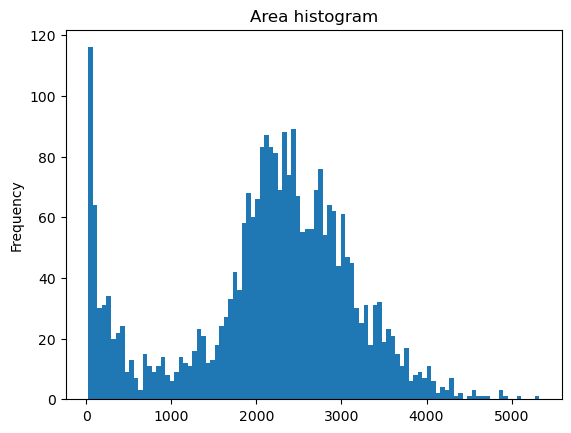

In [8]:
params_df = estimate_parameters_from_labels(stardist_labels, is_timelapse=True)
if in_notebook:
    params_df["area"].plot(kind="hist", bins=100, title="Area histogram")

## Optimize the tracking using optuna and ultrack

In [9]:
config = MainConfig()
pprint(config.dict())

{
│   'data_config': {'n_workers': 1, 'working_dir': '.', 'database': 'sqlite', 'address': None},
│   'segmentation_config': {
│   │   'min_area': 100,
│   │   'max_area': 1000000,
│   │   'n_workers': 1,
│   │   'min_frontier': 0.0,
│   │   'threshold': 0.5,
│   │   'max_noise': 0.0,
│   │   'ws_hierarchy': 'area',
│   │   'anisotropy_penalization': 0.0
│   },
│   'linking_config': {
│   │   'max_distance': 15.0,
│   │   'n_workers': 1,
│   │   'max_neighbors': 5,
│   │   'distance_weight': 0.0,
│   │   'z_score_threshold': 5.0
│   },
│   'tracking_config': {
│   │   'solver_name': '',
│   │   'appear_weight': -0.001,
│   │   'disappear_weight': -0.001,
│   │   'division_weight': -0.001,
│   │   'n_threads': -1,
│   │   'window_size': None,
│   │   'overlap_size': 1,
│   │   'solution_gap': 0.001,
│   │   'time_limit': 36000,
│   │   'method': 0,
│   │   'link_function': 'power',
│   │   'power': 4,
│   │   'bias': -0.0,
│   │   'dismiss_weight_guess': None,
│   │   'include_weight_guess': None
│   }
}

In [13]:
long_track_threshold = 10


def long_track_content_loss_function(tracks_df):
    number_of_tracks = tracks_df["track_id"].nunique()
    longest_track_length = tracks_df.groupby("track_id").size().max()
    number_of_long_tracks = (
        tracks_df["track_id"]
        .value_counts()[tracks_df["track_id"].value_counts() > long_track_threshold]
        .shape[0]
    )
    return number_of_long_tracks


def long_track_loss_function(tracks_df, expected_label_number):
    number_of_tracks = tracks_df["track_id"].nunique()
    longest_track_length = tracks_df.groupby("track_id").size().max()
    number_of_long_tracks = (
        tracks_df["track_id"]
        .value_counts()[tracks_df["track_id"].value_counts() > long_track_threshold]
        .shape[0]
    )
    loss = abs(expected_label_number - number_of_long_tracks)


# create a loss function to evaluate the tracking using the number of tracks and the longest track length
def loss_function(tracks_df):
    # find the number of tracks
    number_of_tracks = tracks_df["track_id"].nunique()
    # get the longest track length
    longest_track_length = tracks_df.groupby("track_id").size().max()
    number_of_long_tracks = (
        tracks_df["track_id"]
        .value_counts()[tracks_df["track_id"].value_counts() > long_track_threshold]
        .shape[0]
    )
    # calculate loss
    # we want to minimize the lossd
    if longest_track_length < long_track_threshold:
        return 1
    try:
        loss = np.sqrt(number_of_tracks / number_of_long_tracks)
    except ZeroDivisionError:
        loss = 1
    return loss

In [14]:
sqlite_path = f"sqlite:///{results_output_dir}/ultrack_trials.db"
# if the database exists, remove it
if os.path.exists(sqlite_path):
    os.remove(sqlite_path)

In [15]:
# set up the optuna study
study = optuna.create_study(
    study_name="cell_tracking",
    storage=f"sqlite:///{results_output_dir}/ultrack_trials.db",
    load_if_exists=False,
    direction="minimize",
)


# set up the objective function
def objective(trial):
    # get the parameters

    min_area = trial.suggest_int("min_area", 10, 49)
    max_area = trial.suggest_int("max_area", 50, 100)
    threshold = trial.suggest_float("threshold", 0.1, 0.9)

    max_distance = trial.suggest_int("max_distance", 5, 50)
    max_neighbors = trial.suggest_int("max_neighbors", 1, 25)
    z_score_threshold = trial.suggest_float("z_score_threshold", 1, 10)

    appear_weight = trial.suggest_float("appear_weight", -0.1, 0)
    disappear_weight = trial.suggest_float("disappear_weight", -0.1, 0)
    division_weight = trial.suggest_float("division_weight", -0.1, 0)
    power = trial.suggest_int("power", 1, 10)
    bias = trial.suggest_float("bias", -0.1, 0)
    solution_gap = trial.suggest_float("solution_gap", 0.0001, 0.1)

    # set up the config
    config = MainConfig()
    config.segmentation_config.min_area = min_area
    config.segmentation_config.max_area = max_area
    config.segmentation_config.threshold = threshold

    config.linking_config.max_distance = max_distance
    config.linking_config.max_neighbors = max_neighbors
    config.linking_config.z_score_threshold = z_score_threshold

    config.tracking_config.appear_weight = appear_weight
    config.tracking_config.disappear_weight = disappear_weight
    config.tracking_config.division_weight = division_weight
    config.tracking_config.power = power
    config.tracking_config.bias = bias
    config.tracking_config.solution_gap = solution_gap
    config.tracking_config.solver_name = "CBC"
    try:
        track(
            foreground=detections,
            edges=edges,
            config=config,
            overwrite=True,
        )
    except ValueError as e:
        print(e)
        return 0
    # get the number of tracks
    tracks_df, graph = to_tracks_layer(config)
    number_of_tracks = tracks_df["track_id"].nunique()
    print(f"There {max_number_of_objects} expected tracks; found {number_of_tracks}")
    tracks_df.head()
    if number_of_tracks == 0:
        return None
    loss = long_track_loss_function(tracks_df, max_number_of_objects)
    return loss


# run the optimization
study.optimize(objective, n_trials=n_trials)

[I 2025-01-15 09:46:31,824] A new study created in RDB with name: cell_tracking
Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 18.51it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 4.8008562689924117e-03
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8022 rows, 12131 columns and 21588 nonzeros
Model fingerprint: 0x53e11af8
Variable types: 0 continuous, 12131 integer (12131 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range 

[W 2025-01-15 09:46:50,949] Trial 0 failed with parameters: {'min_area': 22, 'max_area': 59, 'threshold': 0.3826471454018455, 'max_distance': 18, 'max_neighbors': 11, 'z_score_threshold': 9.326409491186595, 'appear_weight': -0.08539652436898137, 'disappear_weight': -0.07915832103357144, 'division_weight': -0.09157165428763828, 'power': 4, 'bias': -0.001275271940565842, 'solution_gap': 0.004800856268992412} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:46:50,950] Trial 0 failed with value None.


There 218 expected tracks; found 240


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 67.75it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:47:06,365] Trial 1 failed with parameters: {'min_area': 13, 'max_area': 91, 'threshold': 0.6631460700743502, 'max_distance': 35, 'max_neighbors': 5, 'z_score_threshold': 8.093986151441479, 'appear_weight': -0.006086956105928534, 'disappear_weight': -0.0581633676460729, 'division_weight': -0.07825206090786509, 'power': 6, 'bias': -0.056577753828891866, 'solution_gap': 0.04239954293120091} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:47:06,365] Trial 1 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 4.2399542931200913e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 12902 columns and 23134 nonzeros
Model fingerprint: 0xf0c4cd98
Variable types: 0 continuous, 12902 integer (12902 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8008 rows and 12898 columns
Presolve time: 0.08s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 86.7583933
Variable 

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 67.28it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:47:21,910] Trial 2 failed with parameters: {'min_area': 10, 'max_area': 85, 'threshold': 0.8047823441268055, 'max_distance': 25, 'max_neighbors': 8, 'z_score_threshold': 6.19936306891093, 'appear_weight': -0.09852795659069735, 'disappear_weight': -0.05956279951729637, 'division_weight': -0.0832734849364411, 'power': 7, 'bias': -0.04472800127915011, 'solution_gap': 0.07458165274932353} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:47:21,911] Trial 2 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 7.4581652749323532e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 12510 columns and 22350 nonzeros
Model fingerprint: 0x410b693b
Variable types: 0 continuous, 12510 integer (12510 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-05, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7926 rows and 12353 columns
Presolve time: 0.09s
Presolved: 84 rows, 157 columns, 306 nonzeros
Found heuristic solution: objective 56.5205242
Vari

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 63.98it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:47:37,457] Trial 3 failed with parameters: {'min_area': 22, 'max_area': 54, 'threshold': 0.18116795669156938, 'max_distance': 27, 'max_neighbors': 13, 'z_score_threshold': 6.725124367418397, 'appear_weight': -0.0814976656865572, 'disappear_weight': -0.05752844239360562, 'division_weight': -0.09611163257633702, 'power': 5, 'bias': -0.0539972724270382, 'solution_gap': 0.04840513140899574} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:47:37,457] Trial 3 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 4.8405131408995737e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8025 rows, 12633 columns and 22591 nonzeros
Model fingerprint: 0xfb44b5e4
Variable types: 0 continuous, 12633 integer (12633 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-04, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8023 rows and 12629 columns
Presolve time: 0.09s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 113.9570752
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 67.11it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:47:52,638] Trial 4 failed with parameters: {'min_area': 20, 'max_area': 73, 'threshold': 0.4037978385283292, 'max_distance': 27, 'max_neighbors': 6, 'z_score_threshold': 6.497186198030302, 'appear_weight': -0.08983939047884436, 'disappear_weight': -0.08632836595324533, 'division_weight': -0.006923445314456586, 'power': 6, 'bias': -0.06620754255931, 'solution_gap': 0.05894883776589831} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:47:52,638] Trial 4 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 5.8948837765898307e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 12600 columns and 22530 nonzeros
Model fingerprint: 0x0bf3d73c
Variable types: 0 continuous, 12600 integer (12600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8008 rows and 12596 columns
Presolve time: 0.12s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 64.9728709
Variable 

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 63.52it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:48:08,001] Trial 5 failed with parameters: {'min_area': 10, 'max_area': 95, 'threshold': 0.7912716950147372, 'max_distance': 47, 'max_neighbors': 22, 'z_score_threshold': 7.300353952546417, 'appear_weight': -0.03140663587070898, 'disappear_weight': -0.030830243666991955, 'division_weight': -0.08016456587791414, 'power': 8, 'bias': -0.013554926997793232, 'solution_gap': 0.06548726265848409} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:48:08,001] Trial 5 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 6.5487262658484091e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 13237 columns and 23804 nonzeros
Model fingerprint: 0x2446737a
Variable types: 0 continuous, 13237 integer (13237 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8008 rows and 13233 columns
Presolve time: 0.08s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 71.1602477
Variable 

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 68.46it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:48:23,158] Trial 6 failed with parameters: {'min_area': 29, 'max_area': 78, 'threshold': 0.7355007016571257, 'max_distance': 16, 'max_neighbors': 15, 'z_score_threshold': 5.472537352361369, 'appear_weight': -0.04254137103582439, 'disappear_weight': -0.09917002875809745, 'division_weight': -0.049177569401241954, 'power': 5, 'bias': -0.03091221368544847, 'solution_gap': 0.0935750261180538} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:48:23,158] Trial 6 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 0.0935750261180538
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 11946 columns and 21222 nonzeros
Model fingerprint: 0xe09204d8
Variable types: 0 continuous, 11946 integer (11946 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7990 rows and 11911 columns
Presolve time: 0.08s
Presolved: 20 rows, 35 columns, 65 nonzeros
Found heuristic solution: objective 128.2807529
Variable 

Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-15 09:48:38,159] Trial 7 finished with value: 0.0 and parameters: {'min_area': 24, 'max_area': 52, 'threshold': 0.1916962302333631, 'max_distance': 8, 'max_neighbors': 21, 'z_score_threshold': 2.876829491217674, 'appear_weight': -0.07689864235048877, 'disappear_weight': -0.06691913036530353, 'division_weight': -0.02742269436974043, 'power': 5, 'bias': -0.05764501982599405, 'solution_gap': 0.03137270133805504}. Best is trial 7 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 64.85it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:48:53,890] Trial 8 failed with parameters: {'min_area': 23, 'max_area': 79, 'threshold': 0.5120883895654842, 'max_distance': 44, 'max_neighbors': 12, 'z_score_threshold': 4.7498798510760105, 'appear_weight': -0.08327607200404641, 'disappear_weight': -0.059104432875912376, 'division_weight': -0.08391883155275673, 'power': 1, 'bias': -0.07911111562250668, 'solution_gap': 0.0147854344793393} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:48:53,891] Trial 8 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 0.0147854344793393
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 13155 columns and 23640 nonzeros
Model fingerprint: 0xad3fae75
Variable types: 0 continuous, 13155 integer (13155 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-04, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8008 rows and 13151 columns
Presolve time: 0.07s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 795.1782270
Variable typ

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 65.67it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:49:09,597] Trial 9 failed with parameters: {'min_area': 28, 'max_area': 57, 'threshold': 0.8368095236603826, 'max_distance': 34, 'max_neighbors': 10, 'z_score_threshold': 1.9756685946039494, 'appear_weight': -0.04010734291390862, 'disappear_weight': -0.053186084238292075, 'division_weight': -0.07479207861332868, 'power': 1, 'bias': -0.08475500484447364, 'solution_gap': 0.053992945500542275} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:49:09,597] Trial 9 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 5.3992945500542275e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8025 rows, 12899 columns and 23123 nonzeros
Model fingerprint: 0x7b722d8e
Variable types: 0 continuous, 12899 integer (12899 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8023 rows and 12895 columns
Presolve time: 0.07s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 785.6567784
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 66.66it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:49:25,376] Trial 10 failed with parameters: {'min_area': 49, 'max_area': 85, 'threshold': 0.23903024972124456, 'max_distance': 25, 'max_neighbors': 6, 'z_score_threshold': 9.17699112021111, 'appear_weight': -0.07230011126446785, 'disappear_weight': -0.050992410360157774, 'division_weight': -0.014383960605408072, 'power': 8, 'bias': -0.06841272245017821, 'solution_gap': 0.0003131533172706199} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:49:25,376] Trial 10 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 3.1315331727061992e-04
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7998 rows, 12484 columns and 22302 nonzeros
Model fingerprint: 0x01654f0b
Variable types: 0 continuous, 12484 integer (12484 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-04, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7917 rows and 12334 columns
Presolve time: 0.10s
Presolved: 81 rows, 150 columns, 292 nonzeros
Found heuristic solution: objective 34.3417370
Vari

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 66.12it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:49:40,928] Trial 11 failed with parameters: {'min_area': 33, 'max_area': 84, 'threshold': 0.1705087131248651, 'max_distance': 27, 'max_neighbors': 9, 'z_score_threshold': 3.921366434079393, 'appear_weight': -0.025059493502034444, 'disappear_weight': -0.005384149207387584, 'division_weight': -0.05133342321812437, 'power': 9, 'bias': -0.04296295863912863, 'solution_gap': 0.000802985399059937} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:49:40,928] Trial 11 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 0.000802985399059937
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 12605 columns and 22540 nonzeros
Model fingerprint: 0x2aa8d4c6
Variable types: 0 continuous, 12605 integer (12605 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-06, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8008 rows and 12601 columns
Presolve time: 0.07s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 43.9164336
Variable ty

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 66.58it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:49:56,633] Trial 12 failed with parameters: {'min_area': 28, 'max_area': 88, 'threshold': 0.746310920224517, 'max_distance': 24, 'max_neighbors': 13, 'z_score_threshold': 4.223178724863978, 'appear_weight': -0.056374429986682684, 'disappear_weight': -0.0981713003094299, 'division_weight': -0.030408810873176637, 'power': 4, 'bias': -0.029578231958150764, 'solution_gap': 0.05608784182659346} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:49:56,633] Trial 12 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 5.6087841826593460e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8004 rows, 12454 columns and 22240 nonzeros
Model fingerprint: 0xe60f8550
Variable types: 0 continuous, 12454 integer (12454 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7921 rows and 12299 columns
Presolve time: 0.11s
Presolved: 83 rows, 155 columns, 300 nonzeros
Found heuristic solution: objective 198.9435163
Var

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 67.04it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:50:12,441] Trial 13 failed with parameters: {'min_area': 42, 'max_area': 61, 'threshold': 0.5267033782347135, 'max_distance': 28, 'max_neighbors': 9, 'z_score_threshold': 2.7703836394403205, 'appear_weight': -0.013628574991750644, 'disappear_weight': -0.006922705852116101, 'division_weight': -0.09671046046476967, 'power': 1, 'bias': -0.07039254955706488, 'solution_gap': 0.024059333509773365} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:50:12,442] Trial 13 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 2.4059333509773365e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8022 rows, 12667 columns and 22660 nonzeros
Model fingerprint: 0x4edc2202
Variable types: 0 continuous, 12667 integer (12667 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8020 rows and 12663 columns
Presolve time: 0.07s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 814.7448362
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 66.10it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:50:28,460] Trial 14 failed with parameters: {'min_area': 15, 'max_area': 57, 'threshold': 0.5765373695797192, 'max_distance': 36, 'max_neighbors': 4, 'z_score_threshold': 2.50877377467586, 'appear_weight': -0.09319278734665076, 'disappear_weight': -0.04545805325598512, 'division_weight': -0.09195908217038638, 'power': 6, 'bias': -0.0038261780917215327, 'solution_gap': 0.0008270900481907668} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:50:28,460] Trial 14 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 8.2709004819076675e-04
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8025 rows, 12939 columns and 23203 nonzeros
Model fingerprint: 0x9f60f1bf
Variable types: 0 continuous, 12939 integer (12939 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8023 rows and 12935 columns
Presolve time: 0.10s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 126.8435386
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 66.32it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:50:44,068] Trial 15 failed with parameters: {'min_area': 47, 'max_area': 56, 'threshold': 0.3110661472847485, 'max_distance': 30, 'max_neighbors': 16, 'z_score_threshold': 7.8471855454877835, 'appear_weight': -0.06317725143042774, 'disappear_weight': -0.012231795795189793, 'division_weight': -0.09203458909813977, 'power': 7, 'bias': -0.0495689083011912, 'solution_gap': 0.022757274608842484} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:50:44,068] Trial 15 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 2.2757274608842484e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8025 rows, 12752 columns and 22829 nonzeros
Model fingerprint: 0x93e89116
Variable types: 0 continuous, 12752 integer (12752 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8023 rows and 12748 columns
Presolve time: 0.08s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 64.2100470
Variable 

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 61.41it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:50:59,537] Trial 16 failed with parameters: {'min_area': 28, 'max_area': 50, 'threshold': 0.5055529834106426, 'max_distance': 42, 'max_neighbors': 5, 'z_score_threshold': 7.2429499217046, 'appear_weight': -0.07488237229161862, 'disappear_weight': -0.006538756137842286, 'division_weight': -0.05443293199700932, 'power': 3, 'bias': -0.08114307818749443, 'solution_gap': 0.05875420527983687} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:50:59,537] Trial 16 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 5.8754205279836873e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8031 rows, 13137 columns and 23597 nonzeros
Model fingerprint: 0x962006e2
Variable types: 0 continuous, 13137 integer (13137 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-06, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8029 rows and 13133 columns
Presolve time: 0.11s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 252.6434453
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 58.69it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:51:15,070] Trial 17 failed with parameters: {'min_area': 32, 'max_area': 93, 'threshold': 0.6922320182258622, 'max_distance': 13, 'max_neighbors': 15, 'z_score_threshold': 8.450090330012156, 'appear_weight': -0.0334889066511196, 'disappear_weight': -0.08589704501918853, 'division_weight': -0.08415595773250129, 'power': 4, 'bias': -0.06053695226445769, 'solution_gap': 0.04441846030627367} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:51:15,071] Trial 17 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 4.4418460306273673e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 11690 columns and 20710 nonzeros
Model fingerprint: 0x7734e1d8
Variable types: 0 continuous, 11690 integer (11690 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8008 rows and 11685 columns
Presolve time: 0.07s
Presolved: 2 rows, 5 columns, 7 nonzeros
Found heuristic solution: objective 154.3526134
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 66.89it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:51:30,825] Trial 18 failed with parameters: {'min_area': 25, 'max_area': 95, 'threshold': 0.36007583179200575, 'max_distance': 26, 'max_neighbors': 3, 'z_score_threshold': 3.4818834277996555, 'appear_weight': -0.03085991769652427, 'disappear_weight': -0.012756194413567484, 'division_weight': -0.02444025687947174, 'power': 7, 'bias': -0.0439811631683657, 'solution_gap': 0.024338167295163835} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:51:30,825] Trial 18 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 2.4338167295163835e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 12554 columns and 22438 nonzeros
Model fingerprint: 0x8bf55ac7
Variable types: 0 continuous, 12554 integer (12554 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-05, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8008 rows and 12550 columns
Presolve time: 0.09s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 72.5873327
Variable 

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 67.00it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:51:46,518] Trial 19 failed with parameters: {'min_area': 14, 'max_area': 81, 'threshold': 0.2566769086820754, 'max_distance': 18, 'max_neighbors': 21, 'z_score_threshold': 6.102545598687558, 'appear_weight': -0.01748224400450467, 'disappear_weight': -0.07060316932620786, 'division_weight': -0.07380326342002408, 'power': 7, 'bias': -0.06762427931092752, 'solution_gap': 0.03251350735083434} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:51:46,518] Trial 19 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 3.2513507350834338e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 12105 columns and 21540 nonzeros
Model fingerprint: 0x54096541
Variable types: 0 continuous, 12105 integer (12105 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-05, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7984 rows and 12059 columns
Presolve time: 0.08s
Presolved: 26 rows, 46 columns, 86 nonzeros
Found heuristic solution: objective 53.0061181
Variab

Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-15 09:52:01,414] Trial 20 finished with value: 0.0 and parameters: {'min_area': 23, 'max_area': 85, 'threshold': 0.7898491872631322, 'max_distance': 5, 'max_neighbors': 10, 'z_score_threshold': 7.541997053815254, 'appear_weight': -0.03867062996621567, 'disappear_weight': -0.02239571329840863, 'division_weight': -0.0521821508754417, 'power': 2, 'bias': -0.034636194895186864, 'solution_gap': 0.05866984923522245}. Best is trial 7 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-15 09:52:16,574] Trial 21 finished with value: 0.0 and parameters: {'min_area': 10, 'max_area': 57, 'threshold': 0.43333093385953736, 'max_distance': 9, 'max_neighbors': 7, 'z_score_threshold': 3.6963601801686257, 'appear_weight': -0.0887668375521185, 'disappear_weight': -0.06969905686415404, 'division_weight': -0.04257624083744467, 'power': 6, 'bias': -0.02930689872270688, 'solution_gap': 0.062372689946731244}. Best is trial 7 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 66.47it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:52:32,341] Trial 22 failed with parameters: {'min_area': 25, 'max_area': 79, 'threshold': 0.42949013543452486, 'max_distance': 20, 'max_neighbors': 1, 'z_score_threshold': 2.954028824896452, 'appear_weight': -0.022436597851119483, 'disappear_weight': -0.0608788145110297, 'division_weight': -0.07213731769949036, 'power': 1, 'bias': -0.024416791683607456, 'solution_gap': 0.06538468049582327} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:52:32,342] Trial 22 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 6.5384680495823272e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 12170 columns and 21670 nonzeros
Model fingerprint: 0xc17caa68
Variable types: 0 continuous, 12170 integer (12170 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8008 rows and 12166 columns
Presolve time: 0.08s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 780.8525685
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 65.68it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:52:47,834] Trial 23 failed with parameters: {'min_area': 10, 'max_area': 84, 'threshold': 0.6059449228981337, 'max_distance': 23, 'max_neighbors': 11, 'z_score_threshold': 2.779734032083109, 'appear_weight': -0.09253074040213649, 'disappear_weight': -0.07315885031086528, 'division_weight': -0.014323001836582916, 'power': 4, 'bias': -0.01747656664685436, 'solution_gap': 0.07541925767964643} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:52:47,835] Trial 23 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 7.5419257679646426e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 12421 columns and 22172 nonzeros
Model fingerprint: 0xac4d95ed
Variable types: 0 continuous, 12421 integer (12421 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-05, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7927 rows and 12271 columns
Presolve time: 0.11s
Presolved: 83 rows, 150 columns, 292 nonzeros
Found heuristic solution: objective 210.6844586
Var

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 69.37it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:53:03,326] Trial 24 failed with parameters: {'min_area': 40, 'max_area': 83, 'threshold': 0.265152461724508, 'max_distance': 19, 'max_neighbors': 24, 'z_score_threshold': 8.712116763427202, 'appear_weight': -0.06765583691395152, 'disappear_weight': -0.05716702188202508, 'division_weight': -0.005091229488479926, 'power': 5, 'bias': -0.0931524763550031, 'solution_gap': 0.08245597875268278} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:53:03,326] Trial 24 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 8.2455978752682776e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7998 rows, 12162 columns and 21658 nonzeros
Model fingerprint: 0x924017ca
Variable types: 0 continuous, 12162 integer (12162 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7971 rows and 12113 columns
Presolve time: 0.11s
Presolved: 27 rows, 49 columns, 93 nonzeros
Found heuristic solution: objective 86.4897705
Variab

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 55.96it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:53:19,160] Trial 25 failed with parameters: {'min_area': 38, 'max_area': 66, 'threshold': 0.4063668378681137, 'max_distance': 40, 'max_neighbors': 21, 'z_score_threshold': 5.1699213042708685, 'appear_weight': -0.022347037748123244, 'disappear_weight': -0.03197744285006977, 'division_weight': -0.006996530343741009, 'power': 6, 'bias': -0.09251497933952707, 'solution_gap': 0.06047871443566483} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:53:19,160] Trial 25 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 6.0478714435664833e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8013 rows, 13037 columns and 23403 nonzeros
Model fingerprint: 0x76bcd73c
Variable types: 0 continuous, 13037 integer (13037 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-05, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8011 rows and 13033 columns
Presolve time: 0.10s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 68.1112884
Variable 

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 56.65it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:53:34,674] Trial 26 failed with parameters: {'min_area': 47, 'max_area': 93, 'threshold': 0.644907357769552, 'max_distance': 45, 'max_neighbors': 22, 'z_score_threshold': 2.1922400333627823, 'appear_weight': -0.08368718252115186, 'disappear_weight': -0.07279485024100345, 'division_weight': -0.011947448583661521, 'power': 4, 'bias': -0.03866468561144002, 'solution_gap': 0.038011010379776215} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:53:34,674] Trial 26 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 3.8011010379776215e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7995 rows, 13136 columns and 23607 nonzeros
Model fingerprint: 0x8618d8e5
Variable types: 0 continuous, 13136 integer (13136 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-05, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7993 rows and 13132 columns
Presolve time: 0.14s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 193.8092586
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 65.30it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:53:50,915] Trial 27 failed with parameters: {'min_area': 11, 'max_area': 93, 'threshold': 0.5419932303195422, 'max_distance': 10, 'max_neighbors': 7, 'z_score_threshold': 6.843002031485146, 'appear_weight': -0.008809081684645337, 'disappear_weight': -0.06967628846538959, 'division_weight': -0.004733038838699036, 'power': 10, 'bias': -0.08451907626520369, 'solution_gap': 0.0957882333176461} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:53:50,916] Trial 27 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 0.0957882333176461
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 11396 columns and 20122 nonzeros
Model fingerprint: 0x39c6fe60
Variable types: 0 continuous, 11396 integer (11396 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8008 rows and 11392 columns
Presolve time: 0.06s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 18.9986347
Variable type

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 65.17it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:54:06,616] Trial 28 failed with parameters: {'min_area': 35, 'max_area': 65, 'threshold': 0.8819098583536171, 'max_distance': 34, 'max_neighbors': 10, 'z_score_threshold': 4.095783675103854, 'appear_weight': -0.03409088235000285, 'disappear_weight': -0.04635640237322034, 'division_weight': -0.002096285686192606, 'power': 5, 'bias': -0.08623400696680322, 'solution_gap': 0.03487715829625318} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:54:06,617] Trial 28 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 3.4877158296253180e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8019 rows, 12885 columns and 23097 nonzeros
Model fingerprint: 0x1f0e35e8
Variable types: 0 continuous, 12885 integer (12885 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-05, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8017 rows and 12881 columns
Presolve time: 0.11s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 98.7982906
Variable 

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 68.76it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:54:22,026] Trial 29 failed with parameters: {'min_area': 46, 'max_area': 62, 'threshold': 0.16905172425812615, 'max_distance': 17, 'max_neighbors': 11, 'z_score_threshold': 5.5141417767399705, 'appear_weight': -0.09820983543305749, 'disappear_weight': -0.0607207169157285, 'division_weight': -0.06753758360438572, 'power': 4, 'bias': -0.021338568263161523, 'solution_gap': 0.06645058675638776} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:54:22,027] Trial 29 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 6.6450586756387764e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8022 rows, 12051 columns and 21428 nonzeros
Model fingerprint: 0x1ccbee3e
Variable types: 0 continuous, 12051 integer (12051 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7997 rows and 12005 columns
Presolve time: 0.10s
Presolved: 25 rows, 46 columns, 86 nonzeros
Found heuristic solution: objective 195.5315084
Varia

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 66.90it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:54:37,324] Trial 30 failed with parameters: {'min_area': 42, 'max_area': 85, 'threshold': 0.8404503945872406, 'max_distance': 16, 'max_neighbors': 16, 'z_score_threshold': 7.810377203012811, 'appear_weight': -0.04310297730208599, 'disappear_weight': -0.0892480059886043, 'division_weight': -0.026005548299307568, 'power': 5, 'bias': -0.013614382061651734, 'solution_gap': 0.09470205021150535} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:54:37,325] Trial 30 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 9.4702050211505351e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7998 rows, 11927 columns and 21188 nonzeros
Model fingerprint: 0x6e95c6ee
Variable types: 0 continuous, 11927 integer (11927 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7978 rows and 11892 columns
Presolve time: 0.10s
Presolved: 20 rows, 35 columns, 65 nonzeros
Found heuristic solution: objective 146.2362084
Varia

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 64.90it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:54:52,564] Trial 31 failed with parameters: {'min_area': 13, 'max_area': 95, 'threshold': 0.2954254887936545, 'max_distance': 41, 'max_neighbors': 14, 'z_score_threshold': 4.252468055372478, 'appear_weight': -0.08292308756768711, 'disappear_weight': -0.04483434534403063, 'division_weight': -0.02606683366307065, 'power': 1, 'bias': -0.08996407447593313, 'solution_gap': 0.038985411428776706} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:54:52,565] Trial 31 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 3.8985411428776706e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 13068 columns and 23466 nonzeros
Model fingerprint: 0x37a2cc3c
Variable types: 0 continuous, 13068 integer (13068 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8008 rows and 13064 columns
Presolve time: 0.10s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 776.0778741
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 67.50it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:55:07,848] Trial 32 failed with parameters: {'min_area': 40, 'max_area': 50, 'threshold': 0.5571434229946582, 'max_distance': 15, 'max_neighbors': 5, 'z_score_threshold': 6.430193904047847, 'appear_weight': -0.008671844268188317, 'disappear_weight': -0.0018330946548470173, 'division_weight': -0.04183258770410939, 'power': 5, 'bias': -0.05235617985603222, 'solution_gap': 0.09591441468112558} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:55:07,848] Trial 32 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 9.5914414681125576e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8031 rows, 11901 columns and 21125 nonzeros
Model fingerprint: 0x1bb8bbfa
Variable types: 0 continuous, 11901 integer (11901 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8008 rows and 11861 columns
Presolve time: 0.07s
Presolved: 23 rows, 40 columns, 74 nonzeros
Found heuristic solution: objective 140.4133727
Varia

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 24.27it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:55:23,737] Trial 33 failed with parameters: {'min_area': 48, 'max_area': 65, 'threshold': 0.4588602280484083, 'max_distance': 38, 'max_neighbors': 23, 'z_score_threshold': 6.359269587714877, 'appear_weight': -0.054592114949387406, 'disappear_weight': -0.04484557062337194, 'division_weight': -0.07353759236227125, 'power': 3, 'bias': -0.03260345311803857, 'solution_gap': 0.04222563279444055} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:55:23,737] Trial 33 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 4.2225632794440547e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8019 rows, 12998 columns and 23323 nonzeros
Model fingerprint: 0x64694d8f
Variable types: 0 continuous, 12998 integer (12998 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8017 rows and 12994 columns
Presolve time: 0.08s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 318.0859077
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 67.01it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:55:39,289] Trial 34 failed with parameters: {'min_area': 23, 'max_area': 84, 'threshold': 0.27688802464380347, 'max_distance': 40, 'max_neighbors': 1, 'z_score_threshold': 4.330716318333838, 'appear_weight': -0.08341747412643045, 'disappear_weight': -0.0904497594122411, 'division_weight': -0.08132636038984875, 'power': 6, 'bias': -0.059977287607303746, 'solution_gap': 0.08708013616257015} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:55:39,290] Trial 34 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 8.7080136162570154e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 12737 columns and 22804 nonzeros
Model fingerprint: 0x331b347a
Variable types: 0 continuous, 12737 integer (12737 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-05, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8008 rows and 12732 columns
Presolve time: 0.09s
Presolved: 2 rows, 5 columns, 7 nonzeros
Found heuristic solution: objective 69.4282102
Variable 

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 60.09it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:55:54,690] Trial 35 failed with parameters: {'min_area': 13, 'max_area': 91, 'threshold': 0.23140557140483706, 'max_distance': 46, 'max_neighbors': 23, 'z_score_threshold': 5.037849714499611, 'appear_weight': -0.047202067315249466, 'disappear_weight': -0.08819168307160574, 'division_weight': -0.06394687898543852, 'power': 1, 'bias': -0.0770339529246574, 'solution_gap': 0.09255777779808552} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:55:54,690] Trial 35 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 9.2557777798085522e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 13214 columns and 23758 nonzeros
Model fingerprint: 0xf018d3b5
Variable types: 0 continuous, 13214 integer (13214 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8008 rows and 13210 columns
Presolve time: 0.07s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 802.2632971
Variable

Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-15 09:56:09,162] Trial 36 finished with value: 0.0 and parameters: {'min_area': 38, 'max_area': 79, 'threshold': 0.5119224926861465, 'max_distance': 9, 'max_neighbors': 17, 'z_score_threshold': 8.941196226361683, 'appear_weight': -0.01124673484267949, 'disappear_weight': -0.09961643899747555, 'division_weight': -0.08017555891314761, 'power': 8, 'bias': -0.05233471424607555, 'solution_gap': 0.012005731794095996}. Best is trial 7 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 67.00it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:56:24,384] Trial 37 failed with parameters: {'min_area': 24, 'max_area': 50, 'threshold': 0.589731408003783, 'max_distance': 30, 'max_neighbors': 25, 'z_score_threshold': 2.7138153913255834, 'appear_weight': -0.09904513415114441, 'disappear_weight': -0.023334737298801422, 'division_weight': -0.08795504330475862, 'power': 2, 'bias': -0.08686025542948382, 'solution_gap': 0.06569943036767893} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:56:24,384] Trial 37 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 6.5699430367678932e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8031 rows, 12771 columns and 22865 nonzeros
Model fingerprint: 0xdd7d9b93
Variable types: 0 continuous, 12771 integer (12771 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-05, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8029 rows and 12767 columns
Presolve time: 0.10s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 410.9771398
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 62.05it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:56:39,660] Trial 38 failed with parameters: {'min_area': 29, 'max_area': 67, 'threshold': 0.31448671223266916, 'max_distance': 25, 'max_neighbors': 18, 'z_score_threshold': 5.402148203151969, 'appear_weight': -0.010845883098428613, 'disappear_weight': -0.04737939908015953, 'division_weight': -0.020373859446387546, 'power': 4, 'bias': -0.045054257293232536, 'solution_gap': 0.045208136978058} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:56:39,661] Trial 38 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 0.045208136978058
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8016 rows, 12523 columns and 22374 nonzeros
Model fingerprint: 0x2d47f51c
Variable types: 0 continuous, 12523 integer (12523 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7932 rows and 12368 columns
Presolve time: 0.07s
Presolved: 84 rows, 155 columns, 302 nonzeros
Found heuristic solution: objective 199.9740443
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 70.21it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:56:55,067] Trial 39 failed with parameters: {'min_area': 18, 'max_area': 72, 'threshold': 0.4232503213754727, 'max_distance': 13, 'max_neighbors': 17, 'z_score_threshold': 9.806129049358976, 'appear_weight': -0.09314559796155751, 'disappear_weight': -0.061187316329142455, 'division_weight': -0.06610569280467826, 'power': 2, 'bias': -0.05986471309358865, 'solution_gap': 0.025857254610609844} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:56:55,067] Trial 39 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 2.5857254610609844e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 11692 columns and 20714 nonzeros
Model fingerprint: 0x59599172
Variable types: 0 continuous, 11692 integer (11692 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-04, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8008 rows and 11687 columns
Presolve time: 0.10s
Presolved: 2 rows, 5 columns, 7 nonzeros
Found heuristic solution: objective 334.8161873
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 60.78it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:57:11,145] Trial 40 failed with parameters: {'min_area': 43, 'max_area': 88, 'threshold': 0.8838570475664306, 'max_distance': 37, 'max_neighbors': 18, 'z_score_threshold': 5.187826132409155, 'appear_weight': -0.031326564545175004, 'disappear_weight': -0.02211872905281506, 'division_weight': -0.09442603345397181, 'power': 2, 'bias': -0.06768962131905587, 'solution_gap': 0.057928626697845556} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:57:11,145] Trial 40 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 5.7928626697845556e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7992 rows, 12909 columns and 23154 nonzeros
Model fingerprint: 0x9b2e128e
Variable types: 0 continuous, 12909 integer (12909 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-05, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7990 rows and 12905 columns
Presolve time: 0.07s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 459.8639427
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 65.84it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:57:26,872] Trial 41 failed with parameters: {'min_area': 21, 'max_area': 86, 'threshold': 0.19376370277885535, 'max_distance': 28, 'max_neighbors': 7, 'z_score_threshold': 1.763489806463236, 'appear_weight': -0.0988680226478394, 'disappear_weight': -0.018486563035860548, 'division_weight': -0.09593713811658326, 'power': 3, 'bias': -0.08082228393587072, 'solution_gap': 0.07132037048791312} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:57:26,872] Trial 41 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 7.1320370487913121e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8007 rows, 12636 columns and 22603 nonzeros
Model fingerprint: 0x359d631e
Variable types: 0 continuous, 12636 integer (12636 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-05, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8005 rows and 12632 columns
Presolve time: 0.10s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 245.4997442
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 68.53it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:57:42,035] Trial 42 failed with parameters: {'min_area': 48, 'max_area': 86, 'threshold': 0.5203567218942359, 'max_distance': 15, 'max_neighbors': 21, 'z_score_threshold': 5.169934742116865, 'appear_weight': -0.05291183932248359, 'disappear_weight': -0.06599947097091974, 'division_weight': -0.06461408681554753, 'power': 3, 'bias': -0.060748712442862396, 'solution_gap': 0.045517678344451806} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:57:42,035] Trial 42 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 4.5517678344451806e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7995 rows, 11841 columns and 21017 nonzeros
Model fingerprint: 0x7f5ab7e2
Variable types: 0 continuous, 11841 integer (11841 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7977 rows and 11810 columns
Presolve time: 0.07s
Presolved: 18 rows, 31 columns, 57 nonzeros
Found heuristic solution: objective 246.5765394
Varia

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 64.88it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:57:57,449] Trial 43 failed with parameters: {'min_area': 38, 'max_area': 86, 'threshold': 0.4852547211075152, 'max_distance': 47, 'max_neighbors': 19, 'z_score_threshold': 2.2367865406415994, 'appear_weight': -0.08397372494636518, 'disappear_weight': -0.09919073727149763, 'division_weight': -0.02105231320337428, 'power': 9, 'bias': -0.03440042344962796, 'solution_gap': 0.06423864874499828} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:57:57,450] Trial 43 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 6.4238648744998281e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7995 rows, 13183 columns and 23701 nonzeros
Model fingerprint: 0x21a2bb62
Variable types: 0 continuous, 13183 integer (13183 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7993 rows and 13179 columns
Presolve time: 0.11s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 32.1063596
Variable 

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 61.69it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:58:12,744] Trial 44 failed with parameters: {'min_area': 37, 'max_area': 76, 'threshold': 0.7007507206918668, 'max_distance': 24, 'max_neighbors': 12, 'z_score_threshold': 6.43305319223514, 'appear_weight': -0.030376155527141763, 'disappear_weight': -0.022537882740012033, 'division_weight': -0.0635394869172071, 'power': 1, 'bias': -0.03192757586786435, 'solution_gap': 0.04927155975584152} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:58:12,745] Trial 44 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 4.9271559755841521e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8004 rows, 12448 columns and 22228 nonzeros
Model fingerprint: 0x6429ee30
Variable types: 0 continuous, 12448 integer (12448 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-04, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7924 rows and 12301 columns
Presolve time: 0.07s
Presolved: 80 rows, 147 columns, 284 nonzeros
Found heuristic solution: objective 835.8548770
Var

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 68.37it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:58:27,880] Trial 45 failed with parameters: {'min_area': 17, 'max_area': 83, 'threshold': 0.5431107065987514, 'max_distance': 12, 'max_neighbors': 24, 'z_score_threshold': 1.850494222307013, 'appear_weight': -0.017174610685052077, 'disappear_weight': -0.08169267621562093, 'division_weight': -0.055931742677513954, 'power': 4, 'bias': -0.024545199769416423, 'solution_gap': 0.016341701094971215} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:58:27,881] Trial 45 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 1.6341701094971215e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8010 rows, 11590 columns and 20510 nonzeros
Model fingerprint: 0x742efcc9
Variable types: 0 continuous, 11590 integer (11590 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8008 rows and 11586 columns
Presolve time: 0.07s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 181.7162178
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 65.04it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:58:44,007] Trial 46 failed with parameters: {'min_area': 27, 'max_area': 88, 'threshold': 0.1072531748065046, 'max_distance': 43, 'max_neighbors': 23, 'z_score_threshold': 8.254039193313364, 'appear_weight': -0.06722135632948598, 'disappear_weight': -0.09536933358905643, 'division_weight': -0.01532677588259343, 'power': 6, 'bias': -0.030886774778191378, 'solution_gap': 0.0870071763046927} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:58:44,007] Trial 46 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 0.0870071763046927
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8004 rows, 13111 columns and 23554 nonzeros
Model fingerprint: 0x33dc0c0d
Variable types: 0 continuous, 13111 integer (13111 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-06, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8002 rows and 13107 columns
Presolve time: 0.13s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 93.7369148
Variable type

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 68.76it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:58:59,518] Trial 47 failed with parameters: {'min_area': 39, 'max_area': 52, 'threshold': 0.888760020121159, 'max_distance': 12, 'max_neighbors': 24, 'z_score_threshold': 4.7585293070511545, 'appear_weight': -0.01048931832065099, 'disappear_weight': -0.08217326465283381, 'division_weight': -0.02060736508443385, 'power': 7, 'bias': -0.0892769063793063, 'solution_gap': 0.06801857323968348} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:58:59,519] Trial 47 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 6.8018573239683480e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8025 rows, 11618 columns and 20561 nonzeros
Model fingerprint: 0x156d10cd
Variable types: 0 continuous, 11618 integer (11618 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8023 rows and 11614 columns
Presolve time: 0.07s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 43.3070745
Variable 

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 66.08it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:59:14,939] Trial 48 failed with parameters: {'min_area': 23, 'max_area': 66, 'threshold': 0.21973656767667882, 'max_distance': 32, 'max_neighbors': 8, 'z_score_threshold': 9.433537842572626, 'appear_weight': -0.019612420702781408, 'disappear_weight': -0.01595225158039021, 'division_weight': -0.01001963863214514, 'power': 2, 'bias': -0.007298685510060923, 'solution_gap': 0.06774476137267428} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:59:14,939] Trial 48 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 6.7744761372674281e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8016 rows, 12805 columns and 22938 nonzeros
Model fingerprint: 0x0723712f
Variable types: 0 continuous, 12805 integer (12805 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-05, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8014 rows and 12801 columns
Presolve time: 0.12s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 565.1024017
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 65.76it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[W 2025-01-15 09:59:30,404] Trial 49 failed with parameters: {'min_area': 22, 'max_area': 50, 'threshold': 0.6536198487124897, 'max_distance': 23, 'max_neighbors': 6, 'z_score_threshold': 6.728334431008675, 'appear_weight': -0.06737414397986238, 'disappear_weight': -0.010897651759802562, 'division_weight': -0.006811556763308704, 'power': 4, 'bias': -0.004176066941441708, 'solution_gap': 0.025756598930166134} because of the following error: The value None could not be cast to float..
[W 2025-01-15 09:59:30,404] Trial 49 failed with value None.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 2.5756598930166134e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8031 rows, 12462 columns and 22247 nonzeros
Model fingerprint: 0x2c35c137
Variable types: 0 continuous, 12462 integer (12462 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-06, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7946 rows and 12307 columns
Presolve time: 0.11s
Presolved: 85 rows, 155 columns, 301 nonzeros
Found heuristic solution: objective 246.6025819
Var

In [16]:
# plot the optimization results
optuna.visualization.plot_optimization_history(study).write_html(
    f"{figures_output_dir}/tracking_optimization_history.html"
)

In [17]:
optuna.visualization.plot_slice(study).write_html(
    f"{figures_output_dir}/tracking_slice.html"
)

In [18]:
optuna.visualization.plot_contour(study).write_html(
    f"{figures_output_dir}/tracking_contour.html"
)

In [19]:
optuna.visualization.plot_parallel_coordinate(study).write_html(
    f"{figures_output_dir}/tracking_parallel_coordinate.html"
)

In [20]:
# get the best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")
study.best_value

Best parameters: {'min_area': 24, 'max_area': 52, 'threshold': 0.1916962302333631, 'max_distance': 8, 'max_neighbors': 21, 'z_score_threshold': 2.876829491217674, 'appear_weight': -0.07689864235048877, 'disappear_weight': -0.06691913036530353, 'division_weight': -0.02742269436974043, 'power': 5, 'bias': -0.05764501982599405, 'solution_gap': 0.03137270133805504}


0.0

In [21]:
# set up the config with the best parameters
config = MainConfig()
config.segmentation_config.min_area = best_params["min_area"]
config.segmentation_config.max_area = best_params["max_area"]
config.segmentation_config.threshold = best_params["threshold"]

config.linking_config.max_distance = best_params["max_distance"]
config.linking_config.max_neighbors = best_params["max_neighbors"]
config.linking_config.z_score_threshold = best_params["z_score_threshold"]

config.tracking_config.appear_weight = best_params["appear_weight"]
config.tracking_config.disappear_weight = best_params["disappear_weight"]
config.tracking_config.division_weight = best_params["division_weight"]
config.tracking_config.power = best_params["power"]
config.tracking_config.bias = best_params["bias"]
config.tracking_config.solution_gap = best_params["solution_gap"]
pprint(config.dict())
# write the config to a file for reference later
with open(f"{results_output_dir}/ultrack_config.json", "w") as f:
    f.write(config.json())

{
│   'data_config': {'n_workers': 1, 'working_dir': '.', 'database': 'sqlite', 'address': None},
│   'segmentation_config': {
│   │   'min_area': 24,
│   │   'max_area': 52,
│   │   'n_workers': 1,
│   │   'min_frontier': 0.0,
│   │   'threshold': 0.1916962302333631,
│   │   'max_noise': 0.0,
│   │   'ws_hierarchy': 'area',
│   │   'anisotropy_penalization': 0.0
│   },
│   'linking_config': {
│   │   'max_distance': 8,
│   │   'n_workers': 1,
│   │   'max_neighbors': 21,
│   │   'distance_weight': 0.0,
│   │   'z_score_threshold': 2.876829491217674
│   },
│   'tracking_config': {
│   │   'solver_name': '',
│   │   'appear_weight': -0.07689864235048877,
│   │   'disappear_weight': -0.06691913036530353,
│   │   'division_weight': -0.02742269436974043,
│   │   'n_threads': -1,
│   │   'window_size': None,
│   │   'overlap_size': 1,
│   │   'solution_gap': 0.03137270133805504,
│   │   'time_limit': 36000,
│   │   'method': 0,
│   │   'link_function': 'power',
│   │   'power': 5,
│   │   'bias': -0.05764501982599405,
│   │   'dismiss_weight_guess': None,
│   │   'include_weight_guess': None
│   }
}

In [22]:
tracked = False
while not tracked:
    try:
        track(
            foreground=detections,
            edges=edges,
            config=config,
            overwrite=True,
        )
        tracked = True
    except ValueError as e:
        config.linking_config.max_distance += 1
tracks_df, graph = to_tracks_layer(config)

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 23.95it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 3.1372701338055038e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 8025 rows, 11422 columns and 20169 nonzeros
Model fingerprint: 0xa69b299e
Variable types: 0 continuous, 11422 integer (11422 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-04, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range 

In [23]:
# long_track_threshold = 10
# tracks_df.head()
# tracks_df.sort_values("track_id").head(50)
# # print(tracks_df["track_id"].nunique(), tracks_df["id"].nunique())
# # counts for track_id
# print(tracks_df["track_id"].value_counts())
# # get the number of tracks
# number_of_tracks = tracks_df["track_id"].nunique()
# # get the longest track length
# longest_track_length = tracks_df["track_id"].value_counts().max()
# number_of_long_tracks = tracks_df["track_id"].value_counts()[tracks_df["track_id"].value_counts() > long_track_threshold].shape[0]

# # create a loss function to evaluate the tracking using the number of tracks and the longest track length
# def loss_function(tracks_df):
#     # find the number of tracks
#     number_of_tracks = tracks_df["track_id"].nunique()
#     # get the longest track length
#     longest_track_length = tracks_df.groupby("track_id").size().max()
#     number_of_long_tracks = tracks_df["track_id"].value_counts()[tracks_df["track_id"].value_counts() > long_track_threshold].shape[0]
#     # calculate loss
#     # we want to minimize the lossd
#     if longest_track_length < long_track_threshold:
#         return 1
#     loss = np.sqrt(number_of_tracks / number_of_long_tracks)
#     return loss

In [24]:
tracks_df, graph = to_tracks_layer(config)
labels = tracks_to_zarr(config, tracks_df)
tracks_df.to_parquet(
    f"{results_output_dir}/{str(input_dir_main).split('MaxIP_')[1]}_tracks.parquet"
)
print(tracks_df["track_id"].nunique())
print(
    f"There {max_number_of_objects} expected tracks; found {tracks_df['track_id'].nunique()}"
)
tracks_df.head()

Exporting segmentation masks:   0%|          | 0/14 [00:00<?, ?it/s]/home/lippincm/Documents/ultrack/ultrack/core/export/utils.py:92: UserWarning:

Segmentation mask from t = 0 is empty.

Exporting segmentation masks: 100%|██████████| 14/14 [00:00<00:00, 113.41it/s]

217
There 218 expected tracks; found 217


,track_id,t,y,x,id,parent_track_id,parent_id
id,,,,,,,
2000063,1,1,570.0,1857.0,2000063,-1,-1
3000061,1,2,569.0,1850.0,3000061,-1,2000063
4000062,1,3,575.0,1847.0,4000062,-1,3000061
5000060,1,4,573.0,1855.0,5000060,-1,4000062
6000058,1,5,571.0,1861.0,6000058,-1,5000060


In [25]:
# save the tracks as parquet
tracks_df.reset_index(drop=True, inplace=True)
tracks = np.zeros((len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16)
cum_tracks_df = tracks_df.copy()
timepoints = tracks_df["t"].unique()

# zero out the track_df
cum_tracks_df = cum_tracks_df.loc[cum_tracks_df["t"] == -1]

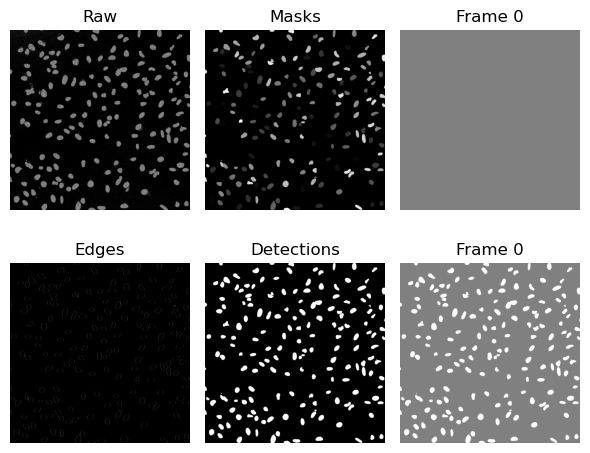

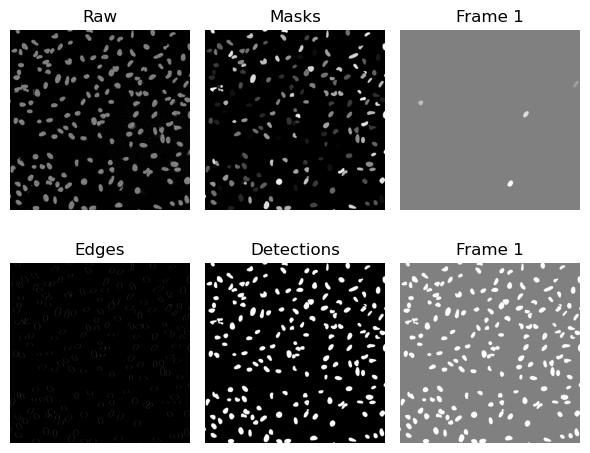

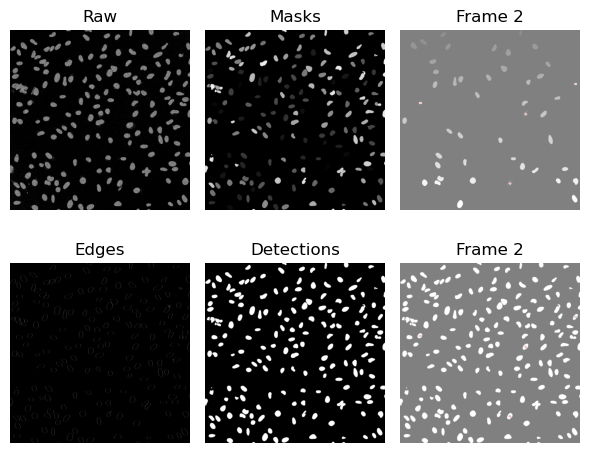

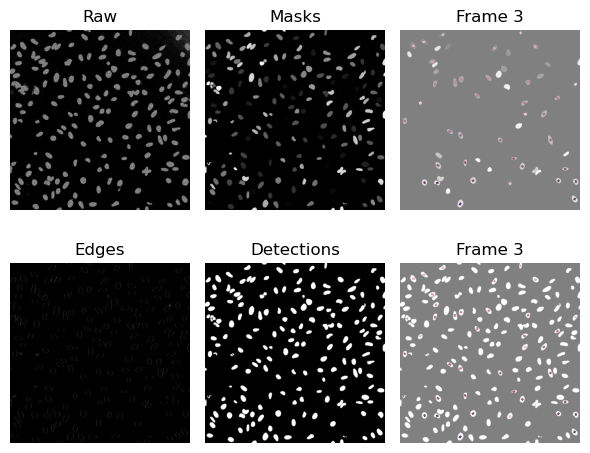

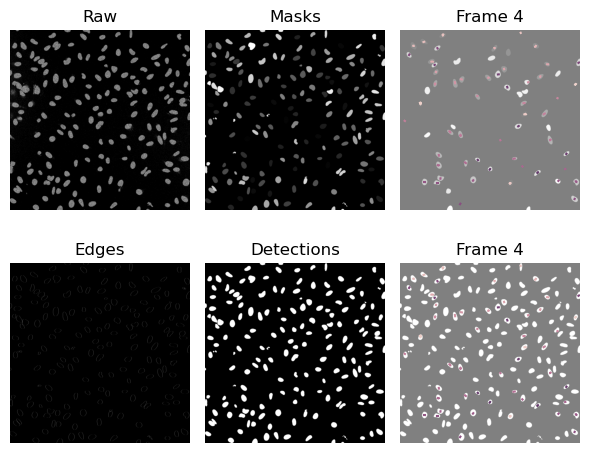

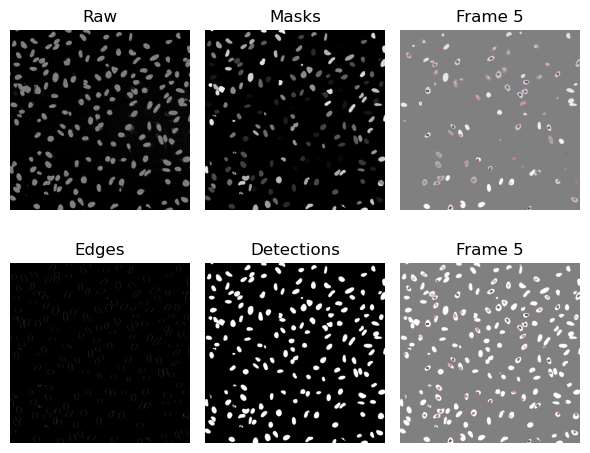

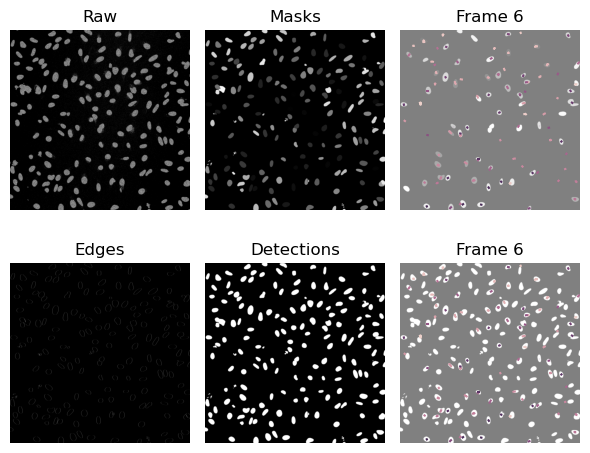

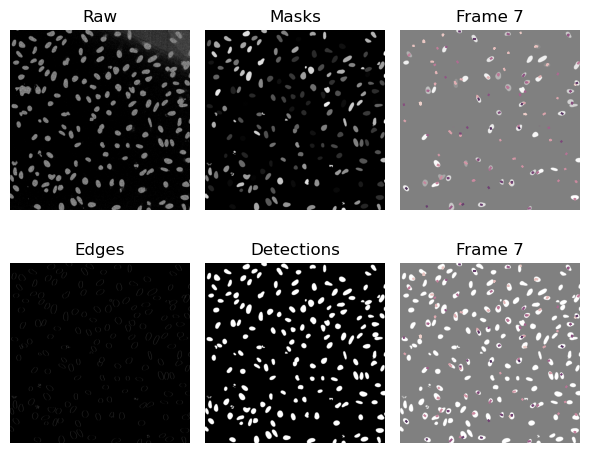

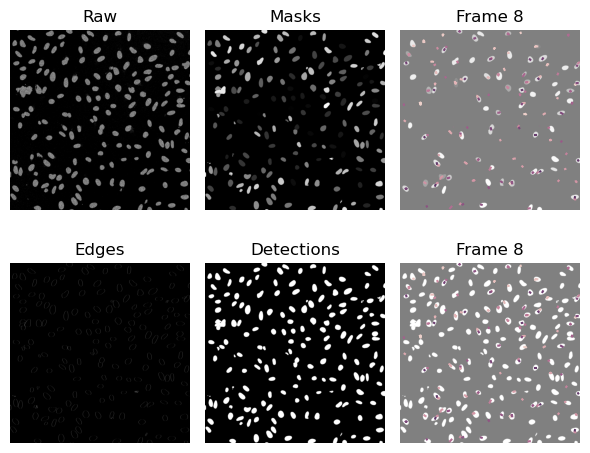

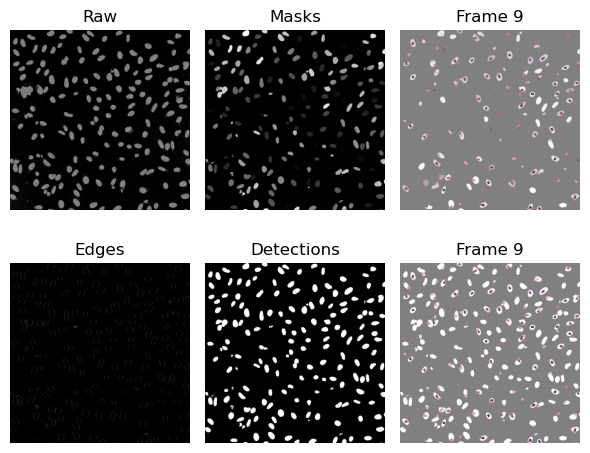

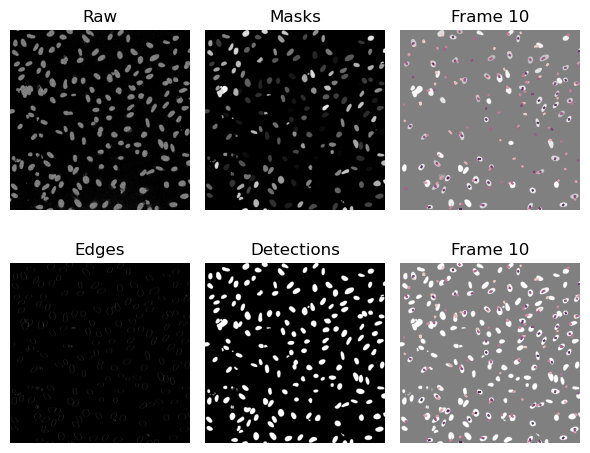

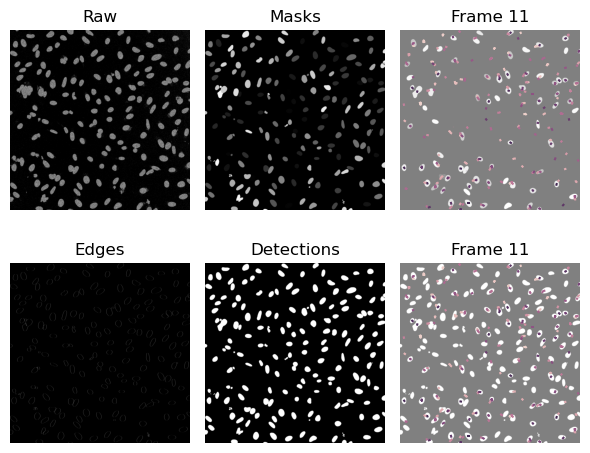

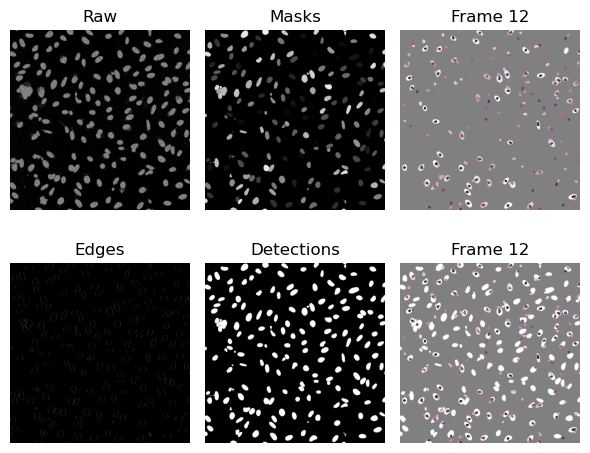

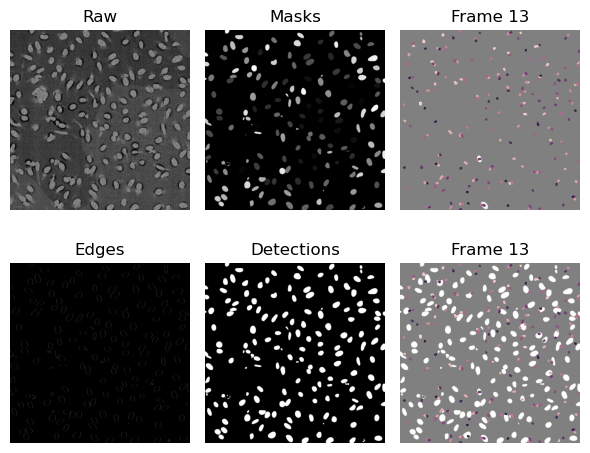

In [26]:
if in_notebook:
    for frame_index, _ in enumerate(timelapse_raw):
        tmp_df = tracks_df.loc[tracks_df["t"] == frame_index]
        cum_tracks_df = pd.concat([cum_tracks_df, tmp_df])
        plt.figure(figsize=(6, 5))
        plt.subplot(2, 3, 1)
        # rescale tbe intensity of the raw image
        raw_image = timelapse_raw_visualize[frame_index, :, :]
        raw_image = raw_image * 4096
        plt.imshow(raw_image, cmap="gray")
        plt.title("Raw")
        plt.axis("off")

        plt.subplot(2, 3, 2)
        plt.imshow(stardist_labels[frame_index, :, :], cmap="gray")
        plt.title("Masks")
        plt.axis("off")

        plt.subplot(2, 3, 3)
        sns.lineplot(data=cum_tracks_df, x="x", y="y", hue="track_id", legend=False)
        plt.imshow(labels[frame_index, :, :], cmap="gray", alpha=0.5)
        plt.title(f"Frame {frame_index}")
        plt.axis("off")

        plt.subplot(2, 3, 4)
        edge_image = skimage.exposure.adjust_gamma(
            edges[frame_index, :, :], gamma=0.0001
        )
        # make the outline brighter
        edge_image = edge_image * 1000
        plt.imshow(edge_image, cmap="gray")
        plt.title("Edges")
        plt.axis("off")

        plt.subplot(2, 3, 5)
        plt.imshow(detections[frame_index, :, :], cmap="gray")
        plt.title("Detections")
        plt.axis("off")

        plt.subplot(2, 3, 6)
        sns.lineplot(data=cum_tracks_df, x="x", y="y", hue="track_id", legend=False)
        plt.imshow(detections[frame_index, :, :], cmap="gray", alpha=0.5)
        plt.title(f"Frame {frame_index}")
        plt.axis("off")

        plt.tight_layout()
        plt.savefig(f"{temporary_output_dir}/tracks_{frame_index}.png")
    if in_notebook:
        plt.show()

In [27]:
# load each image
files = [f for f in temporary_output_dir.glob("*.png")]
files = sorted(files, key=lambda x: int(x.stem.split("_")[1]))
frames = [Image.open(f) for f in files]
fig_path = figures_output_dir / f"{str(input_dir_main).split('MaxIP_')[1]}_tracks.gif"
# plot the line of each track in matplotlib over a gif
# get the tracks
# save the frames as a gif
frames[0].save(fig_path, save_all=True, append_images=frames[1:], duration=3, loop=0)

In [28]:
# clean up tracking files
# remvoe temporary_output_dir
shutil.rmtree(temporary_output_dir)

track_db_path = pathlib.Path("data.db").resolve()
metadata_toml_path = pathlib.Path("metadata.toml").resolve()
if track_db_path.exists():
    track_db_path.unlink()
if metadata_toml_path.exists():
    metadata_toml_path.unlink()

In [ ]:
clear_gpu_memory()

: 